# Suspicious Score

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn import preprocessing

In [3]:
def load_dataset(path):
    df = pd.read_csv(path, index_col=0)
    return df

In [4]:
def look_at_group(group_id, df_charlotte_2016, df_groups):
    df = df_charlotte_2016.merge(df_groups, on='user_id')
    df = df[df.group_id==group_id]
    indexes = df.index
    for _index in indexes:
        text = df.loc[_index].text
        user_id = df.loc[_index].user_id
        business_id = df.loc[_index].business_id
        review_id = df.loc[_index].review_id
        print({'user_id':user_id, 'business_id': business_id , 'review_id': review_id})
        print(text)
        
    return df

## Raw Dataset

In [5]:
df_charlotte_2016 = load_dataset(r'D:\Yelp\charlotte_2016.csv')

In [6]:
df_charlotte_2016.head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_business,review_count,...,categories,hours,review_id,user_id,stars_review,useful,funny,cool,text,date
8,0pOlmHVeidsh63iAWdTAfg,Hendrick Motors of Charlotte - Mercedes-Benz,5201 E Independence Blvd,Charlotte,NC,28212.0,35.188018,-80.758758,2.5,32,...,"Auto Repair, Car Dealers, Automotive","{'Monday': '0:0-0:0', 'Tuesday': '7:30-19:0', ...",VyiezkRspGtuG68_rDYp3A,A0R17nyHQ9SiqQjtnsP33g,1.0,5,0,0,Mercedes used to be such a great brand with ex...,2016-12-23 03:54:01


## Group Dataset

In [7]:
df_groups = load_dataset(r'D:\Yelp\charlotte_2016_groups.csv')

In [8]:
df_groups.tail()

,user_id,group_id,group_len,group_type
38276,hWDybu_KvYLSdEFzGrniTw,10385,6,a
38278,mcJ-A0OGmiWZGBbdWPMfrw,10386,6,a
38279,hWDybu_KvYLSdEFzGrniTw,10386,6,a
38280,xDl9ZF3SckkZde_48W6WeA,10386,6,a
38283,jcURiDqCLY7AOqo8KClJnQ,10386,6,a


In [9]:
df_groups.group_type.value_counts()

n    22741
a    10662
Name: group_type, dtype: int64

In [10]:
df_groups.group_id.max()

10386

## Reviewing Burstiness (BST) data

In [11]:
df_bst = load_dataset(r'D:\Yelp\bst_own_review_count_groups.csv')

In [12]:
df_bst.head(5)

,user_id,bst,own_review_count
0,--3WaS23LcIXtxyFULJHTA,0.964286,2
1,--7D3lFxyMYvs2JYiRrg6Q,0.000000,1
2,--JS-RvSykutl1DavCbkIg,0.000000,1
3,--OZO4c_vDOVC2z2BWr92A,0.964286,2
4,--wiweOmNCw6vg2kbzbwEA,0.000000,1


## Cosine similarity

In [13]:
df_cosine_similarity = load_dataset(r'D:\Yelp\cosine_groups.csv')

In [14]:
df_cosine_similarity.head(1)

,group_id,cosine_mean,cosine_max
0,0,0.319787,0.562996


## Extreme Raiting Abuse (EXT)

In [15]:
df_extreme_rating = load_dataset(r'D:\Yelp\extreme_rating_abuse.csv')

In [16]:
df_extreme_rating.head()

,user_id,ext
0,--3WaS23LcIXtxyFULJHTA,0
1,--7D3lFxyMYvs2JYiRrg6Q,1
2,--JS-RvSykutl1DavCbkIg,1
3,--wiweOmNCw6vg2kbzbwEA,1
4,-0CTuvVqlEGeWvOt82B7Hg,0


---

# Merge for Group! Features

In [17]:
df_g_features = df_charlotte_2016.merge(df_groups, on='user_id', how='inner')

In [18]:
df_g_features.shape

(435220, 25)

---

In [19]:
df_g_features = df_g_features.merge(df_bst, on='user_id', how='inner') 

---

In [20]:
df_g_features = df_g_features.merge(df_extreme_rating, on='user_id', how='inner') 

---

## Reduce

In [21]:
df_g_features_reduced = df_g_features[['group_id', 'group_len', 'group_type', 'bst', 'own_review_count', 'ext']]

In [22]:
df_g_features_reduced.head()

,group_id,group_len,group_type,bst,own_review_count,ext
0,6835,2,n,0.0,2,1
1,6835,2,n,0.0,2,1
2,589,2,n,0.0,35,0
3,1023,14,n,0.0,35,0
4,1024,12,n,0.0,35,0


---

## Build Group Features

In [23]:
bst_mean = df_g_features_reduced.groupby('group_id').bst.mean().to_frame(name='bst_mean')

In [24]:
ext_mean = df_g_features_reduced.groupby('group_id').ext.mean().to_frame(name='ext_mean')

In [25]:
group_review_count_sum = df_g_features_reduced.groupby('group_id').own_review_count.sum().to_frame(name='group_review_count_sum')

In [26]:
group_review_count_mean = df_g_features_reduced.groupby('group_id').own_review_count.mean().to_frame(name='group_review_count_mean')

---

## Merge Group Features

In [27]:
df_group_features = df_g_features_reduced.merge(ext_mean, on='group_id')

In [28]:
df_group_features = df_group_features.merge(group_review_count_sum, on='group_id')

In [29]:
df_group_features = df_group_features.merge(group_review_count_mean, on='group_id')

In [30]:
df_group_features = df_group_features.merge(df_cosine_similarity, on='group_id')

In [31]:
df_group_features = df_group_features.merge(bst_mean, on='group_id')

In [32]:
df_group_features.head()

,group_id,group_len,group_type,bst,own_review_count,ext,ext_mean,group_review_count_sum,group_review_count_mean,cosine_mean,cosine_max,bst_mean
0,6835,2,n,0.0,2,1,1.000000,5,1.666667,0.290987,0.464794,0.0
1,6835,2,n,0.0,2,1,1.000000,5,1.666667,0.290987,0.464794,0.0
2,6835,2,n,0.0,1,1,1.000000,5,1.666667,0.290987,0.464794,0.0
3,589,2,n,0.0,35,0,0.027778,1226,34.055556,0.216525,0.630271,0.0
4,589,2,n,0.0,35,0,0.027778,1226,34.055556,0.216525,0.630271,0.0


In [33]:
df_group_features.shape

(435220, 12)

---

## normalize

In [34]:
df_group_features['group_review_count_sum_normal'] = df_group_features['group_review_count_sum']/df_group_features['group_review_count_sum'].max()

In [35]:
df_group_features['group_review_count_mean_normal'] = df_group_features['group_review_count_mean']/df_group_features['group_review_count_mean'].max()

In [36]:
df_group_features.head()

,group_id,group_len,group_type,bst,own_review_count,ext,ext_mean,group_review_count_sum,group_review_count_mean,cosine_mean,cosine_max,bst_mean,group_review_count_sum_normal,group_review_count_mean_normal
0,6835,2,n,0.0,2,1,1.000000,5,1.666667,0.290987,0.464794,0.0,0.000055,0.008291
1,6835,2,n,0.0,2,1,1.000000,5,1.666667,0.290987,0.464794,0.0,0.000055,0.008291
2,6835,2,n,0.0,1,1,1.000000,5,1.666667,0.290987,0.464794,0.0,0.000055,0.008291
3,589,2,n,0.0,35,0,0.027778,1226,34.055556,0.216525,0.630271,0.0,0.013600,0.169422
4,589,2,n,0.0,35,0,0.027778,1226,34.055556,0.216525,0.630271,0.0,0.013600,0.169422


In [37]:
df_group_features.index = df_group_features.index.map(str)

## Add suspicious score

In [38]:
df_group_features.columns

Index(['group_id', 'group_len', 'group_type', 'bst', 'own_review_count', 'ext',
       'ext_mean', 'group_review_count_sum', 'group_review_count_mean',
       'cosine_mean', 'cosine_max', 'bst_mean',
       'group_review_count_sum_normal', 'group_review_count_mean_normal'],
      dtype='object')

In [74]:
df_group_features['suspicious_score'] =  (df_group_features['bst_mean'] 
                                            + df_group_features['ext_mean'] 
                                            + df_group_features['cosine_mean'] 
                                            )/3

In [75]:
df_group_features = df_group_features.sort_values(by='suspicious_score', ascending=False)

## remove dublicates

In [76]:
df_group_features.shape

(10387, 15)

In [77]:
df_group_features = df_group_features.drop_duplicates(subset='group_id')

In [78]:
df_group_features.shape

(10387, 15)

In [79]:
df_group_features.head()

,group_id,group_len,group_type,bst,own_review_count,ext,ext_mean,group_review_count_sum,group_review_count_mean,cosine_mean,cosine_max,bst_mean,group_review_count_sum_normal,group_review_count_mean_normal,suspicious_score
420526,6868,2,n,0.964286,3,1,1.0,18,3.000000,0.440318,0.704904,0.964286,0.000200,0.014925,0.801534
435192,4089,2,n,0.000000,1,1,1.0,5,1.666667,0.780472,1.000000,0.571429,0.000055,0.008291,0.783967
425414,3156,2,n,0.000000,1,1,1.0,5,1.666667,0.691066,0.973269,0.642857,0.000055,0.008291,0.777975
179955,4423,2,n,0.964286,2,1,1.0,8,2.000000,0.358964,0.609847,0.964286,0.000089,0.009950,0.774417
323865,1358,2,n,0.964286,2,1,1.0,8,2.000000,0.354264,0.492545,0.964286,0.000089,0.009950,0.772850


---

<AxesSubplot:title={'center':'suspicious_score'}>

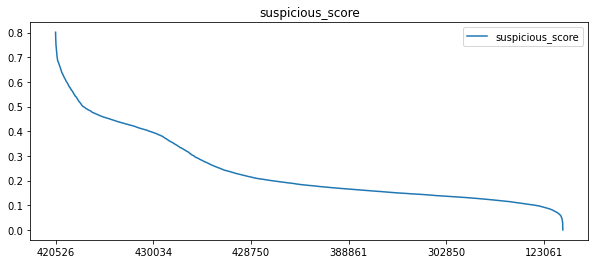

In [80]:
df_group_features[['suspicious_score']].plot(kind='line', figsize=(10,4), title='suspicious_score')

<AxesSubplot:title={'center':'group_len'}>

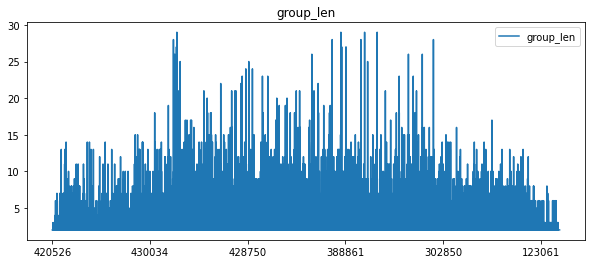

In [81]:
df_group_features[['group_len']].plot(kind='line', figsize=(10,4), title='group_len')

<AxesSubplot:>

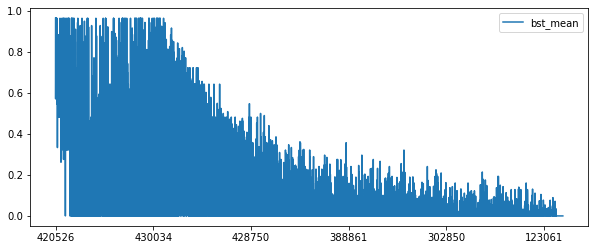

In [82]:
df_group_features[['bst_mean']].plot(kind='line', figsize=(10,4))

<AxesSubplot:>

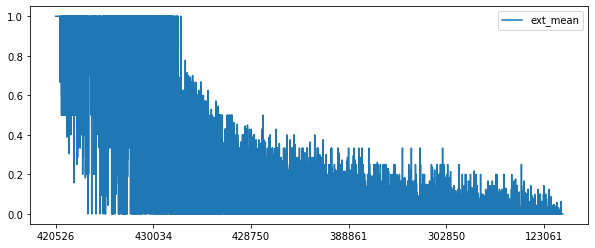

In [83]:
df_group_features[['ext_mean']].plot(kind='line', figsize=(10,4))

<AxesSubplot:>

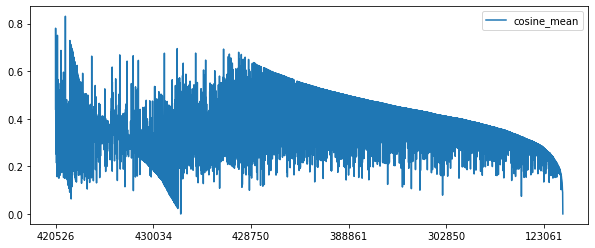

In [84]:
df_group_features[['cosine_mean']].plot(kind='line', figsize=(10,4))

<AxesSubplot:>

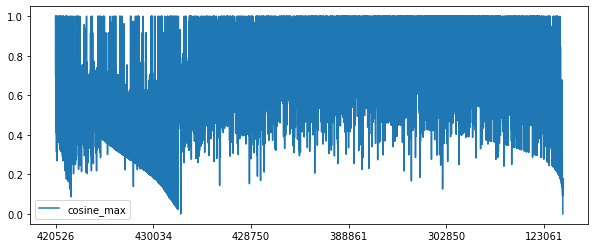

In [85]:
df_group_features[['cosine_max']].plot(kind='line', figsize=(10,4))

<AxesSubplot:>

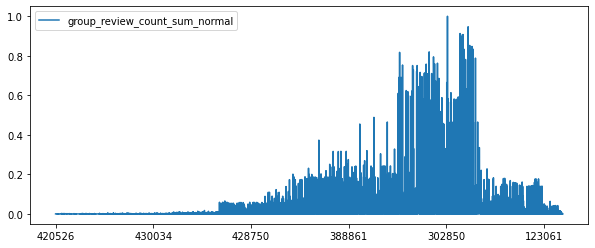

In [86]:
df_group_features[['group_review_count_sum_normal']].plot(kind='line', figsize=(10,4))

<AxesSubplot:>

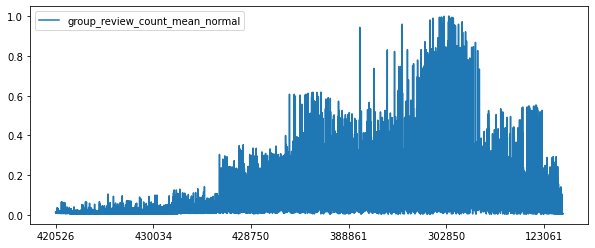

In [87]:
df_group_features[['group_review_count_mean_normal']].plot(kind='line', figsize=(10,4))

## Looking at a group

In [73]:
look_at_group(3156, df_charlotte_2016, df_groups)

{'user_id': 'yL9kq9jALecBHvJQP-MY8g', 'business_id': 'HmAQq1Wbz2oAFX-KqTAM_A', 'review_id': 'j9WO1SrtqRs4wcW60Nu8ig'}
So we paid American Airlines $1028.00 for a flight that happened to be connecting in Charlotte NC - because the flight crew was late, we didn't leave from Jacksonville on time which made us late getting to our connecting flight.  When we arrived in NC, we discovered that the flights as been postponed for 10 minutes - we rushed to join the line only to be told after standing there for a few minutes, only 1 set was left.  I looked at the monitor and saw that several standbys had taken a lot of the seats (ours included)!   When we asked the attendees, we were told no standbys were on the flight - LIE / we went to customer service and was told we couldn't fly until the next day - we were given a voucher to stay at this hotel.  We travel the world - we are in and out of hotels often.  This was by far the worse.  No clocks, no working shower, tags were so thin you could see t

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_business,review_count,...,user_id,stars_review,useful,funny,cool,text,date,group_id,group_len,group_type
402863,HmAQq1Wbz2oAFX-KqTAM_A,American Airlines,"5501 Josh Birmingham Pkwy, Unit 11",Charlotte,NC,28208.0,35.220154,-80.942871,1.5,482,...,yL9kq9jALecBHvJQP-MY8g,1.0,0,0,0,So we paid American Airlines $1028.00 for a fl...,2016-06-22 09:34:52,3156,2,n
402866,J7As1iazdxHnXv03Ex8HDg,Motel 6,4416 S Tryon St,Charlotte,NC,28217.0,35.185307,-80.886133,1.5,10,...,yL9kq9jALecBHvJQP-MY8g,1.0,0,0,0,So we paid American Airlines $1028.00 for a fl...,2016-06-22 09:09:15,3156,2,n
434309,J7As1iazdxHnXv03Ex8HDg,Motel 6,4416 S Tryon St,Charlotte,NC,28217.0,35.185307,-80.886133,1.5,10,...,zs02WPrLkfA2wZIWYeHu4w,1.0,0,0,0,You get what you pay for and I didn't pay anyt...,2016-06-18 05:58:53,3156,2,n
